In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams["axes.edgecolor"] = "black"

# EDA 

In [2]:
# Load cleaned from data cleaning
df = pd.read_csv('datasets/cleaned.csv')

In [3]:
df

,number,code,price,num_digits
0,1313,U,109000,4
1,3222,H,72000,4
2,30033,P,24000,5
3,7765,L,17500,4
4,8876,U,17500,4
...,...,...,...,...
3835,7210,Q,9200,4
3836,6353,E,15000,4
3837,91181,R,6500,5
3838,8704,Q,6600,4


In [4]:
# LGTM
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840 entries, 0 to 3839
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   number      3840 non-null   int64 
 1   code        3840 non-null   object
 2   price       3840 non-null   int64 
 3   num_digits  3840 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 120.1+ KB


## Target / Number of digits sanity checks

In [5]:
# new col for # digits
# Datatype switcheroo for producing new colum with less loc
df['number'] = df['number'].astype(str)
df['num_digits'] = df['number'].apply(lambda x: len(x))
df['number'] = df['number'].astype(int)

df.head()

,number,code,price,num_digits
0,1313,U,109000,4
1,3222,H,72000,4
2,30033,P,24000,5
3,7765,L,17500,4
4,8876,U,17500,4


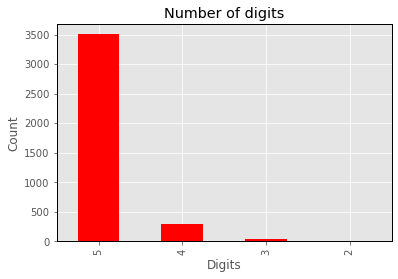

In [6]:
# plot # digits for dataviz
df['num_digits'].value_counts().plot(kind = 'bar', color = 'red');
plt.title('Number of digits');
plt.xlabel('Digits');
plt.ylabel('Count');

In [7]:
# same dataviz but this time numbers. 
# This poses dillemma of should I drop 
# the lesser numbers to balance dataset. 
# However number of digits is a v.imp feature
df['num_digits'].value_counts()

5    3505
4     297
3      36
2       2
Name: num_digits, dtype: int64

In [8]:
# Given 5 is the most common # plate, 
# Our models evaluation metrics will have to satisfy these numbers
# basically get RMSE, MAE as close to std as possible
# If higher than STD, model is unfeasible 
# However results could go off kilter with <5 digits
df.loc[df['num_digits'] == 5,'price'].describe()

count    3.505000e+03
mean     5.605649e+03
std      5.496686e+04
min      1.234000e+03
25%      2.400000e+03
50%      2.600000e+03
75%      3.000000e+03
max      2.990000e+06
Name: price, dtype: float64

In [9]:
# Seems to me there is much more room for error here
# Producing a model within these metrics wouldn't be hard
df.loc[df['num_digits'] != 5,'price'].describe()

count    3.350000e+02
mean     8.920710e+04
std      2.231985e+05
min      1.000000e+00
25%      1.090000e+04
50%      1.650000e+04
75%      5.550000e+04
max      2.250000e+06
Name: price, dtype: float64

In [10]:
# As expected somewhere in between
# This might prove to be difficult
df['price'].describe()

count    3.840000e+03
mean     1.289900e+04
std      8.745635e+04
min      1.000000e+00
25%      2.400000e+03
50%      2.600000e+03
75%      3.000000e+03
max      2.990000e+06
Name: price, dtype: float64

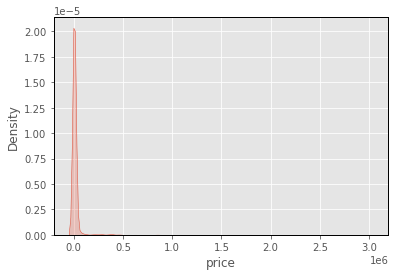

In [11]:
# distribution of price
sns.kdeplot(df["price"], shade=True);

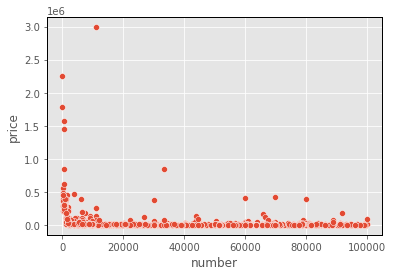

In [12]:
# Scatter of price against #
sns.scatterplot(x = 'number', y = 'price', data = df);

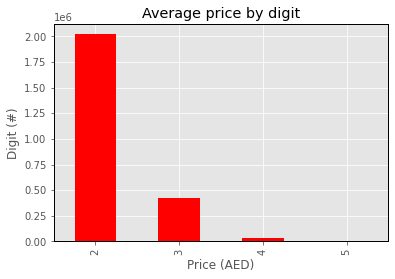

In [13]:
# Average price # digits
df.groupby(['num_digits'])['price'].mean().plot(kind = 'bar', color = 'red');
plt.title('Average price by digit');
plt.xlabel('Price (AED)');
plt.ylabel('Digit (#)');

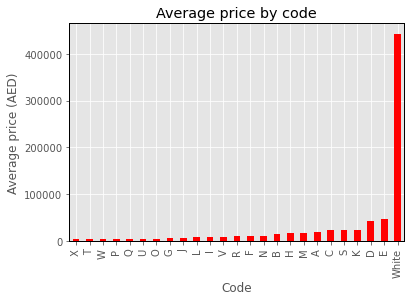

In [14]:
# Plot average price by code
only_fives = df.loc[df['num_digits'] == 5]
b_plot = only_fives.groupby(['code'])['price'].mean().sort_values()
b_plot.plot(kind = 'bar', color = 'red');
plt.title('Average price by code');
plt.xlabel('Code');
plt.ylabel('Average price (AED)');

#price of H looks to be high, need to investigate that 
# Original plan to to one hot encode the codes but it seems to me a better idea would be to 
# Label encode H as a higher value. 

In [15]:
# investigating the trend seen before further
# Seems to me two outlier values
# But could not be outliers based on feature extarction need to investigate that
# Needs one hot encoding anyways
df.loc[df['code'] == 'White']

,number,code,price,num_digits
2989,1996,White,215000,4
3204,60011,White,6899,5
3275,666,White,1570000,3
3348,91800,White,15000,5
3355,30103,White,12500,5
3530,1898,White,16000,4
3538,444,White,1450000,3
3578,4868,White,14500,4
3604,33333,White,850000,5
3621,62,White,1790000,2


In [16]:
# There is a trend
# Less # of unique digits and a pattern
# Will help in feature engineering
df.loc[df['price'] > 10000].head()

,number,code,price,num_digits
0,1313,U,109000,4
1,3222,H,72000,4
2,30033,P,24000,5
3,7765,L,17500,4
4,8876,U,17500,4


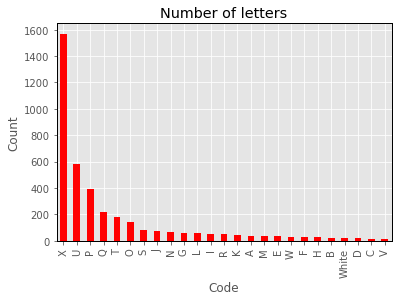

In [17]:
# just need to see if the count of the codes
df['code'].value_counts().plot(kind = 'bar', color = 'red');
plt.title('Number of letters');
plt.xlabel('Code');
plt.ylabel('Count');
# Its seems to me that H is not a majority and most are mindane values
# This is good news as I can feed the data in directly without any preprocessing

In [18]:
df.to_csv('datasets/cleaned.csv', index = False)